The same preprocessed dataset is being used in both comp.ipynb and try.ipynb notebook

The preprocessed dataset is being created from Huwaei Private Cloud 2023 from following directories
    <li>1. Requests Per Minute </li>
    <li>2. CPU Usage Per Minute </li>
    <li>3. Memory Usage Per Minute </li>

### NBEATS

In [50]:
import pandas as pd
from darts import TimeSeries
from darts.models import NBEATSModel, TCNModel  # You can try other models like TFTModel, TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
import torch
import numpy as np
from darts.metrics import mse, rmse, mape

In [51]:
df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)

In [70]:
df[-288:]

,requests,memory,cpu
timestamp,,,
2023-10-01 19:12:00,29.0,0.112,0.004
2023-10-01 19:13:00,28.0,0.112,0.003
2023-10-01 19:14:00,12.0,0.112,0.004
2023-10-01 19:15:00,13.0,0.111,0.003
2023-10-01 19:16:00,13.0,0.113,0.004
...,...,...,...
2023-10-01 23:55:00,16.0,0.106,0.003
2023-10-01 23:56:00,12.0,0.107,0.003
2023-10-01 23:57:00,6.0,0.107,0.003


In [53]:
df = df.fillna(method='ffill', axis=1).fillna(0)

/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_39611/3304020842.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)


In [54]:
# Normalize the data (optional but recommended)
scaler_target = Scaler(MinMaxScaler())
scaler_covariates = Scaler(MinMaxScaler())

# Convert to Darts TimeSeries
series_target = TimeSeries.from_dataframe(df, value_cols=["requests"]).astype(np.float32)
series_covariates = TimeSeries.from_dataframe(df, value_cols=["memory", "cpu"]).astype(np.float32)

# Normalize
series_target = scaler_target.fit_transform(series_target)
series_covariates = scaler_covariates.fit_transform(series_covariates)


In [55]:
type(series_target), type(series_covariates)

(darts.timeseries.TimeSeries, darts.timeseries.TimeSeries)

In [65]:
# Define train-test split
train_size = 0.8  # 80% training, 20% testing
train_target, test_target = series_target.split_after(train_size)
train_covariates, test_covariates = series_covariates.split_after(train_size)


In [57]:
tcnmodel = TCNModel(input_chunk_length=24,  output_chunk_length=12, random_state=42)

tcnmodel.fit(train_target, past_covariates=train_covariates, epochs=10, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 164    | train
-------------------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 35/35 [00:00<00:00, 123.43it/s, train_loss=0.0371]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 35/35 [00:00<00:00, 123.17it/s, train_loss=0.0371]


TCNModel(output_chunk_shift=0, kernel_size=3, num_filters=3, num_layers=None, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=24, output_chunk_length=12, random_state=42)

In [58]:
# Initialize the model (you can also try TransformerModel, TFTModel, RNNModel, etc.)
nbeatsModel = NBEATSModel(
    input_chunk_length=24,   # Number of past time steps to use
    output_chunk_length=12,  # Number of future steps to predict
    random_state=42,
    pl_trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
)

nbeatsModel.fit(series=train_target, past_covariates=train_covariates, epochs=10, verbose=True)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.6 M  | train
-------------------------------------------------------------
6.6 M     Trainable params
1.7 K     Non-trainable params
6.6 M     Total params
26.314    Total estimated model params size (MB)
396       Modules in train mode
0         M

Epoch 9: 100%|██████████| 35/35 [00:01<00:00, 27.68it/s, train_loss=0.0183]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 35/35 [00:01<00:00, 27.66it/s, train_loss=0.0183]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42, pl_trainer_kwargs={'accelerator': 'cpu'})

In [78]:
test_covariates_extended = series_covariates[-(len(test_target) + nbeatsModel.input_chunk_length):]

#nbeats model predcition
nbeats_pred_series = nbeatsModel.predict(n=len(test_target),past_covariates=test_covariates_extended)

#tcn model prediction
tcn_pred_series = tcnmodel.predict(n=len(test_target), past_covariates=test_covariates_extended)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 15.25it/s]

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


 NBEATS Model Metrics

In [80]:
print("MSE:", mse(test_target, nbeats_pred_series))
print("RMSE:", rmse(test_target, nbeats_pred_series))

MSE: 0.044636395
RMSE: 0.21127327


TCN MODEL METRICS

In [81]:
print("MSE:", mse(test_target, tcn_pred_series))
print("RMSE:", rmse(test_target, tcn_pred_series))

MSE: 0.047217634
RMSE: 0.21729618


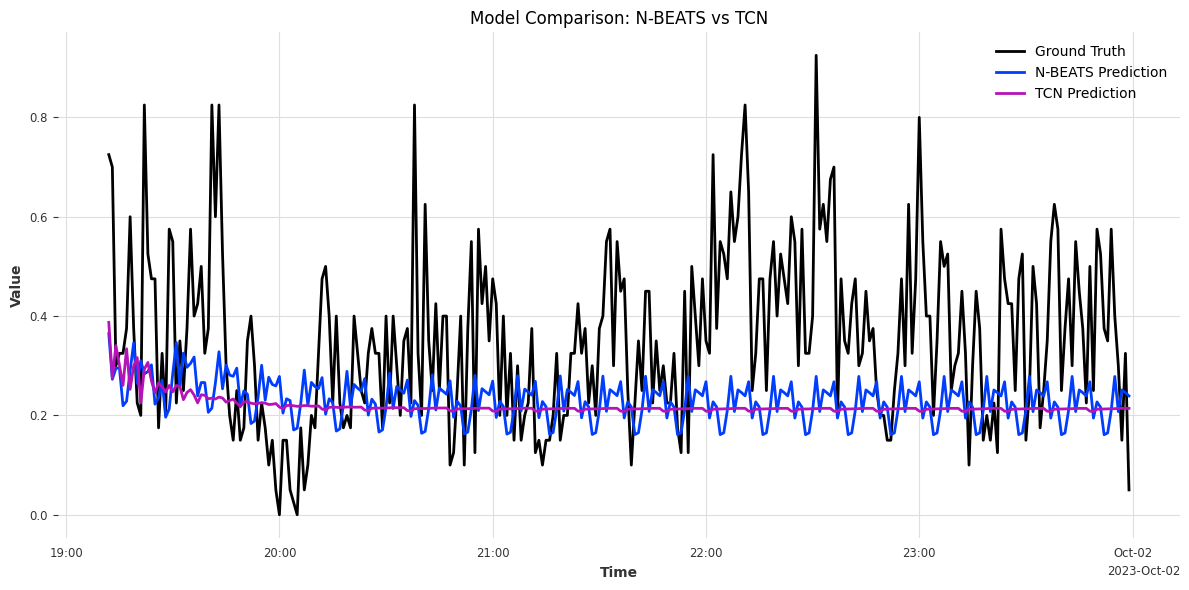

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

test_target.plot(label="Ground Truth")
nbeats_pred_series.plot(label="N-BEATS Prediction")
tcn_pred_series.plot(label="TCN Prediction")

plt.title("Model Comparison: N-BEATS vs TCN")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


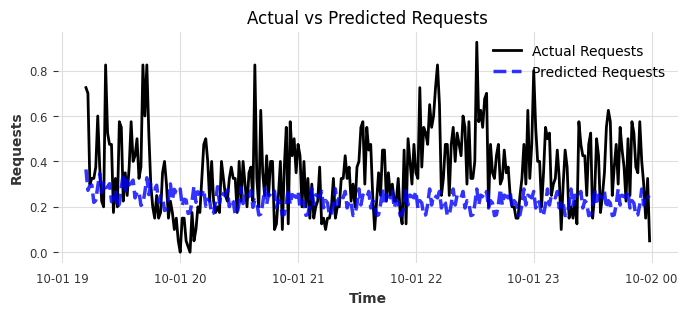

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 3))

test_target_pd = test_target.to_series()
pred_series_pd = nbeats_pred_series.to_series()

plt.plot(test_target_pd, label="Actual Requests", linewidth=2, color="black")

# Plot predicted data with better visibility
plt.plot(pred_series_pd, label="Predicted Requests", linestyle="dashed", linewidth=2.5, color="blue", alpha=0.8)

plt.title("Actual vs Predicted Requests")
plt.xlabel("Time")
plt.ylabel("Requests")
plt.legend()
plt.grid(True)
plt.show()


### ARIMA

In [28]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv("preprocessed_dataset.csv", parse_dates=["timestamp"])

In [13]:
# did the forward fill
df = df.fillna(method='ffill', axis=1).fillna(0)

/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_25198/2194621746.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill', axis=1).fillna(0)
/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_25198/2194621746.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(method='ffill', axis=1).fillna(0)
/var/folders/zh/qb2hlbtn0hl1_57lzc2757k40000gn/T/ipykernel_25198/2194621746.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

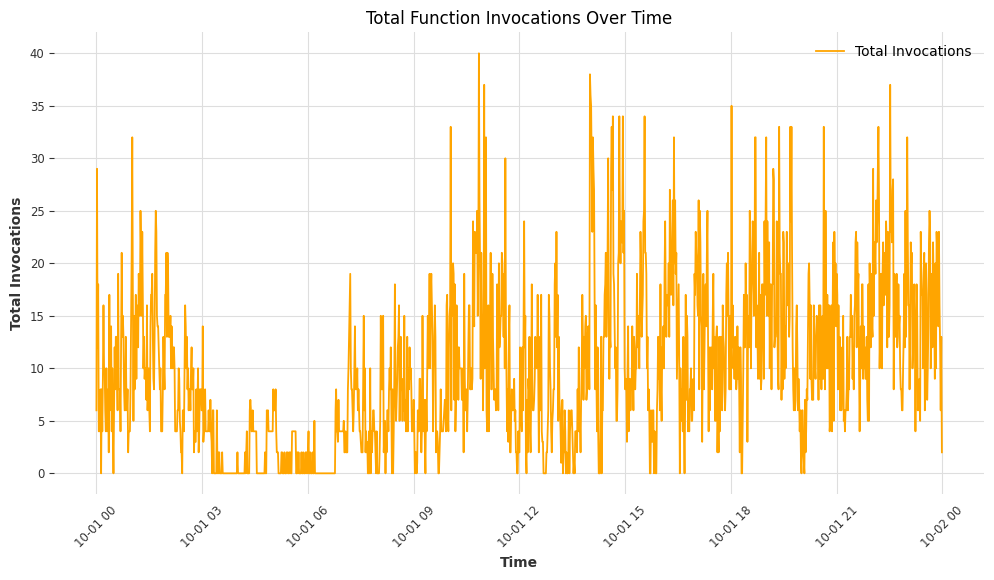

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['requests'], label="Total Invocations", color='orange')
plt.xlabel("Time")
plt.ylabel("Total Invocations")
plt.title("Total Function Invocations Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### find the p,q,d values for ARIMA

Function for determining whether data is stationary or not

In [16]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

time_series = df['requests']
def adf_test(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

    if result[1] < 0.05:
        print("Conclusion: The series is stationary (d=0).")
    else:
        print("Conclusion: The series is NOT stationary. Differencing required (d=1).")

# Run ADF test
adf_test(time_series)

ADF Statistic: -3.5635634074044034
p-value: 0.0064970645211175964
Critical Values:
	1%: -3.434979825137732
	5%: -2.8635847436211317
	10%: -2.5678586114197954
Conclusion: The series is stationary (d=0).


PACF Plot for determining p

<Figure size 1200x500 with 0 Axes>

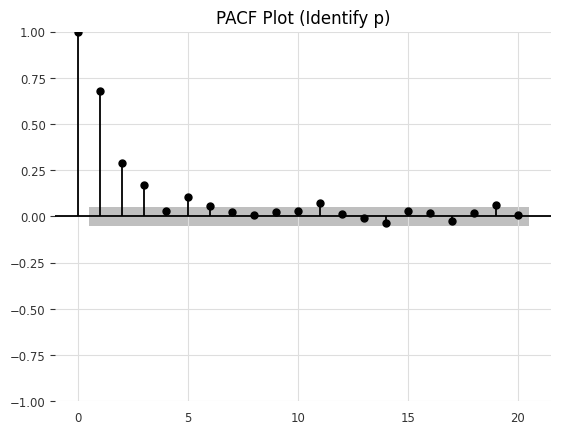

In [18]:
plt.figure(figsize=(12, 5))
plot_pacf(df['requests'], lags=20)
plt.title("PACF Plot (Identify p)")
plt.show()

p = 3 have largest spike, so p = 3

<Figure size 1200x500 with 0 Axes>

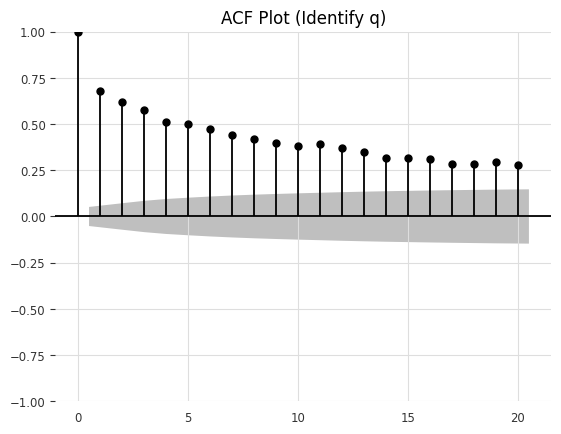

In [19]:
plt.figure(figsize=(12, 5))
plot_acf(df['requests'], lags=20)
plt.title("ACF Plot (Identify q)")
plt.show()

there is not much difference in spikes, so just choose q = 0

In [21]:
# Ensure time is the index
df.set_index('timestamp', inplace=True)

# Train-Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)  # 80% data for training
train, test = df.iloc[:train_size], df.iloc[train_size:]

Using library for dynamically determining the values of p, q and d

In [23]:
import pmdarima as pm

auto_model = pm.auto_arima(train['requests'], seasonal=False, stepwise=True, suppress_warnings=True)

print(auto_model.order)  # (p, d, q)


/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/sklearn/utils/deprec

(3, 1, 1)


In [24]:
# Train ARIMA Model
arima_model = ARIMA(train['requests'], order=(3,1,1)).fit()

# Forecast
arima_forecast = arima_model.forecast(len(test))

/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)
/Users/surajojha/projects/time_series/tenv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency min will be used.
  self._init_dates(dates, freq)


In [25]:
import numpy as np

# Function to compute evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))  # Root Mean Squared Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true+1))) * 100  # Mean Absolute Percentage Error

    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

In [26]:
metrics = evaluate_forecast(test['requests'], arima_forecast)

In [27]:
print(f"ARIMA Model Metrics:")
print(f"MAE: {metrics['MAE']:.2f}")
print(f"RMSE: {metrics['RMSE']:.2f}")
print(f"MAPE: {metrics['MAPE']:.2f}")

ARIMA Model Metrics:
MAE: 5.65
RMSE: 6.94
MAPE: 65.55
